# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import glob
path = 'data/final/train/'
all_files = glob.glob(path + '*.csv')
# list to append csvs
l = []
# loop over all files
for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=0)
    l.append(df_tmp)

# Add all data frames together
df = pd.concat(l, axis=0, ignore_index=True)

In [3]:
df.columns

Index(['backers_count', 'blurb', 'category', 'country', 'currency', 'slug',
       'staff_pick', 'state', 'usd_pledged', 'usd_type', 'goal_usd',
       'word_count', 'month_launched', 'days_running'],
      dtype='object')

In [4]:
df.describe().round(2)

,backers_count,usd_pledged,goal_usd,word_count,month_launched,days_running
count,163395.00,163395.00,163395.00,163395.00,163395.00,163395.00
mean,76.61,5987.27,9289.00,18.96,6.44,32.20
std,129.70,11227.37,13816.54,5.08,3.36,11.58
min,0.00,0.00,0.01,1.00,1.00,1.00
25%,5.00,152.00,1312.00,16.00,4.00,30.00
50%,29.00,1681.00,4000.00,20.00,6.00,30.00
75%,87.00,6294.17,10000.00,22.00,9.00,33.00
max,999.00,99905.00,99999.00,64.00,12.00,93.00


## Category

In [5]:
print("There are {} different categories in the given dataset!".format(df.category.unique().shape[0]))

There are 15 different categories in the given dataset!


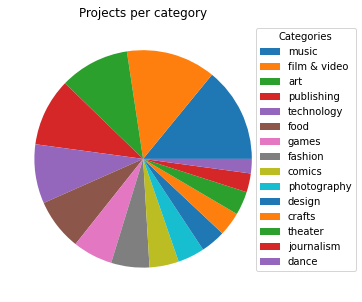

In [6]:
category = df.category.value_counts()
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(category)
ax.legend(category.index,
          title="Categories",
          loc="upper right",
          bbox_to_anchor=(1.3,1),
          prop={'size': 10});
ax.set_title('Projects per category');

In [7]:
count_total = df.query('state != "live"').category.value_counts().sort_index()

category = df.groupby('category')

count_success = category.state.apply(lambda x: (x=='successful').sum()).reset_index(name='count')

category = pd.DataFrame({'category': count_success['category'],
                         'total': count_total.values,
                         'success': count_success['count'],
                         'success_rate': count_success['count']/count_total.values})

category = category.sort_values('success_rate', ascending=False).round(2)

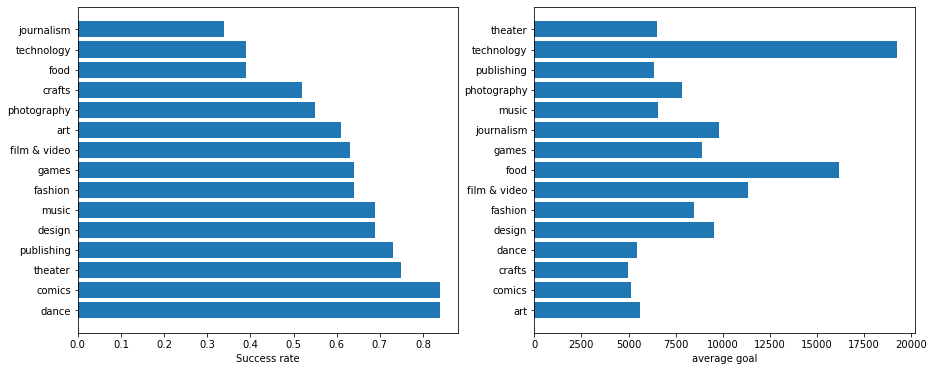

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].barh(category.category, category.success_rate)
ax[0].set_xlabel('Success rate');

category = df.groupby('category').mean()
ax[1].barh(category.index, category.goal_usd)
ax[1].set_xlabel('average goal');


# Sort average goal values the same as left!!!!!!!!!!

Clearly some categories are more successful then others! Can be used as __dummy varibles__, but maybe need to include one 'other' dummy to account for not given categories! Also to make clear to customer, that some categories are probable to fail!\
Technology needs lots of  money, maybe that's a reason for bad success rate. Opposite for dance and comics, need very few money and have a good success rate!

# Quartals launched at
Compare the quartal the project launched, with the count of projects and the success rate.

In [9]:
quarter = {1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 3, 8: 3, 9: 3, 10: 4, 11: 4, 12: 4}
df['launched_quarter'] = [quarter[i] for i in df.month_launched]

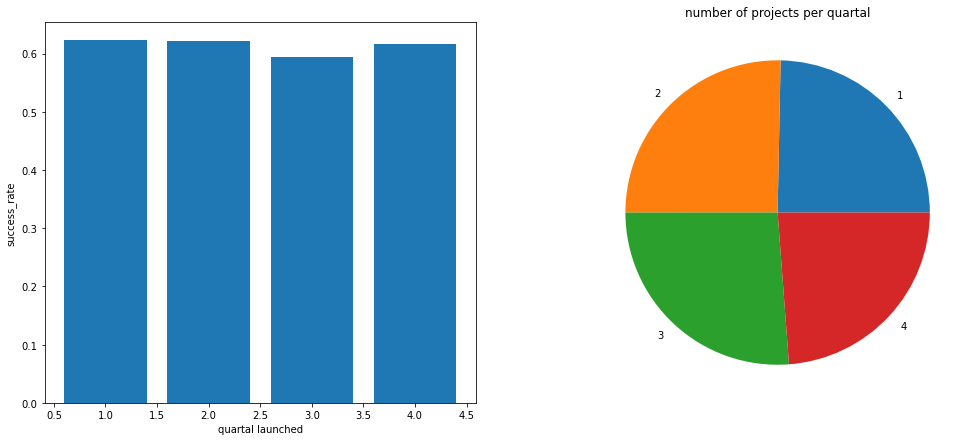

In [10]:
quarter = df.groupby('launched_quarter')
quarter_df = quarter.state.apply(lambda x: (x=='successful').sum()).reset_index(name='count_success')
quarter_df['count_total'] = quarter.size().values

fig, ax = plt.subplots(1,2, figsize=(17,7))
ax[0].bar(quarter_df.launched_quarter, quarter_df.count_success/quarter_df.count_total);
ax[0].set_xlabel('quartal launched')
ax[0].set_ylabel('success_rate')
ax[1].pie(quarter_df.count_total, labels=quarter_df.launched_quarter);
ax[1].set_title('number of projects per quartal');

Time of year has no influence on projects success, project can be started at any time!

# Days of project from start to end

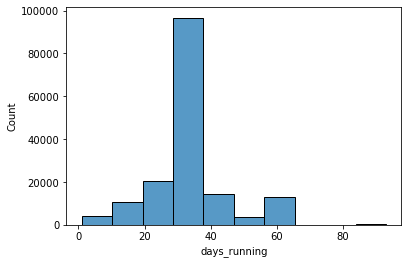

In [11]:
sns.histplot(data=df, x='days_running', bins=10);

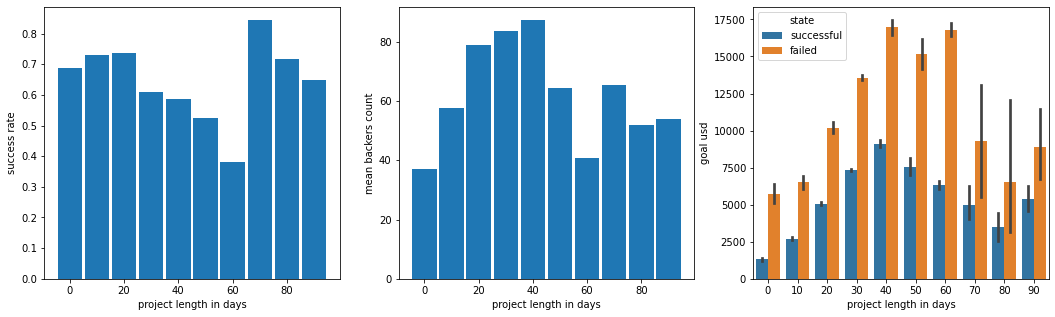

In [12]:
tmp_df = df.copy()
stepsize=10
labels = np.arange(0, df.days_running.max(), stepsize)
nbins = labels.shape[0]
tmp_df['bins'] = pd.cut(df.days_running, bins=nbins, labels=labels)

width = 9
days = tmp_df.groupby('bins')
days_df = days.state.apply(lambda x: (x=='successful').sum()).reset_index(name='count_success')
days_df['count_total'] = days.size().values
days_df['rate'] = days_df.count_success/days_df.count_total

fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].bar(days_df.bins, days_df.count_success/days_df.count_total, width=width);
ax[0].set_xlabel('project length in days')
ax[0].set_ylabel('success rate')

days = tmp_df.groupby('bins').mean()
ax[1].bar(days.index, days.backers_count, width=width)
ax[1].set_xlabel('project length in days')
ax[1].set_ylabel('mean backers count')

days = tmp_df.groupby('bins').mean()
sns.barplot(data=tmp_df, x='bins', y='goal_usd', hue='state', ax=ax[2])
#ax[2].bar(days.index, days.usd_pledged, width=width)
ax[2].set_xlabel('project length in days')
ax[2].set_ylabel('goal usd');

Most __successful__ projects are either __short (20 days)__. The high successrate at long days is due to missing observations (see histogram). Most money/bakers settle for medium sized projects (20-40 days)

# Blurb length

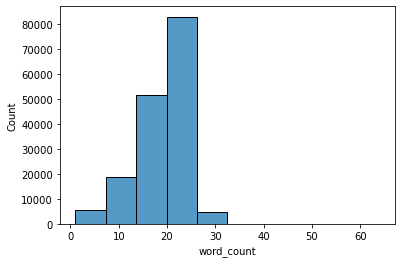

In [13]:
sns.histplot(data=df, x='word_count', bins=10);

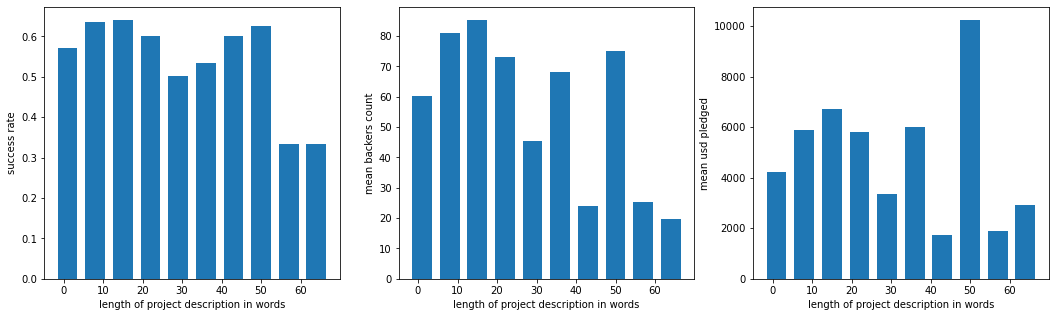

In [14]:
nbins=10
width = 5
x_feature = 'word_count'

tmp_df = df.copy()
labels = np.linspace(df[x_feature].min(), df[x_feature].max(), nbins)
tmp_df['bins'] = pd.cut(df[x_feature], bins=nbins, labels=labels)
x_feature = 'bins'

tmp = tmp_df.groupby(x_feature)
tmp2_df = tmp.state.apply(lambda x: (x=='successful').sum()).reset_index(name='success')
tmp2_df['total'] = tmp.size().values
tmp2_df['rate'] = tmp2_df.success/tmp2_df.total

fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].bar(tmp2_df[x_feature], tmp2_df.success/tmp2_df.total, width=width);
ax[0].set_xlabel('length of project description in words')
ax[0].set_ylabel('success rate')

tmp = tmp_df.groupby(x_feature).mean()
ax[1].bar(tmp.index, tmp.backers_count, width=width)
ax[1].set_xlabel('length of project description in words')
ax[1].set_ylabel('mean backers count')

tmp = tmp_df.groupby(x_feature).mean()
ax[2].bar(tmp.index, tmp.usd_pledged, width=width)
ax[2].set_xlabel('length of project description in words')
ax[2].set_ylabel('mean usd pledged');

Descriptions of __10 to 40 words get most backers__. Probably because efficient description, not too much to read.

In [15]:
# Plot goal, success_rate and word_count together!

# Country

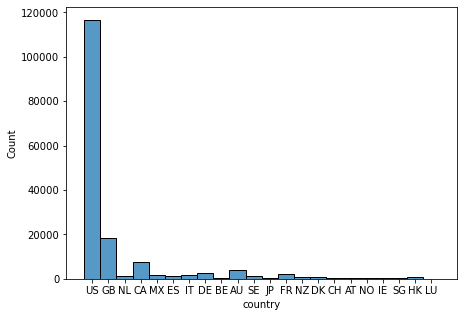

In [16]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(data=df, x='country', ax=ax);

Most projects are from US!

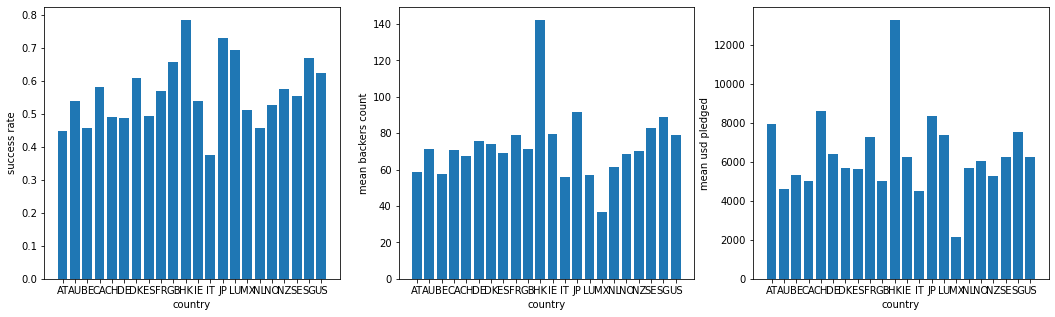

In [17]:
tmp = df.groupby('country')
tmp_df = tmp.state.apply(lambda x: (x=='successful').sum()).reset_index(name='success')
tmp_df['total'] = tmp.size().values
tmp_df['rate'] = tmp_df.success/tmp_df.total

fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].bar(tmp_df.country, tmp_df.success/tmp_df.total);
ax[0].set_xlabel('country')
ax[0].set_ylabel('success rate')

tmp = df.groupby('country').mean()
ax[1].bar(tmp.index, tmp.backers_count)
ax[1].set_xlabel('country')
ax[1].set_ylabel('mean backers count')

tmp = df.groupby('country').mean()
ax[2].bar(tmp.index, tmp.usd_pledged)
ax[2].set_xlabel('country')
ax[2].set_ylabel('mean usd pledged');

Success does not depend on country! Hard to say, because not many observations outside of US!

# Currency

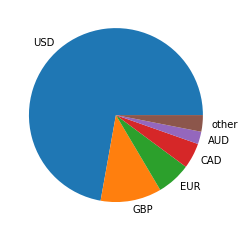

In [18]:
first_five = df.currency.value_counts()[:5]
rest = df.currency.value_counts()[6:].sum()
series = pd.Series(rest, index=['other'])
first_five = first_five.append(series)
plt.pie(first_five, labels=first_five.index);

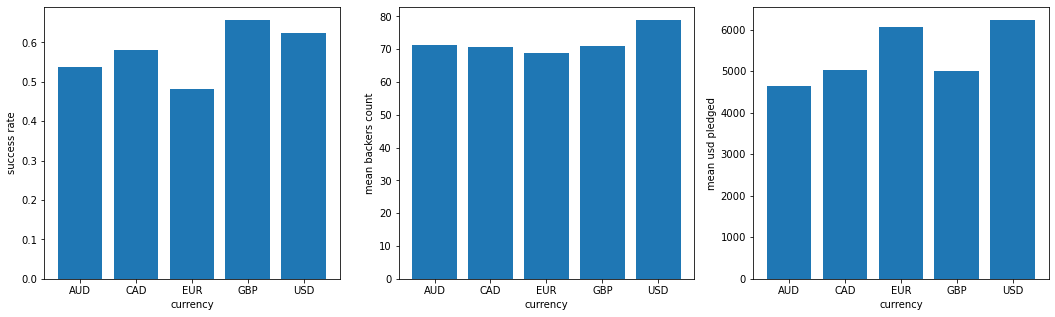

In [19]:
tmp = df.query('currency == ["USD", "GBP", "EUR", "CAD", "AUD", "rest"]').groupby('currency')
tmp_df = tmp.state.apply(lambda x: (x=='successful').sum()).reset_index(name='success')
tmp_df['total'] = tmp.size().values
tmp_df['rate'] = tmp_df.success/tmp_df.total

fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].bar(tmp_df.currency, tmp_df.success/tmp_df.total);
ax[0].set_xlabel('currency')
ax[0].set_ylabel('success rate')

tmp = df.query('currency == ["USD", "GBP", "EUR", "CAD", "AUD", "rest"]').groupby('currency').mean()
ax[1].bar(tmp.index, tmp.backers_count)
ax[1].set_xlabel('currency')
ax[1].set_ylabel('mean backers count')

tmp = df.query('currency == ["USD", "GBP", "EUR", "CAD", "AUD", "rest"]').groupby('currency').mean()
ax[2].bar(tmp.index, tmp.usd_pledged)
ax[2].set_xlabel('currency')
ax[2].set_ylabel('mean usd pledged');

Currency/Region is not really important.

# staff_pick

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


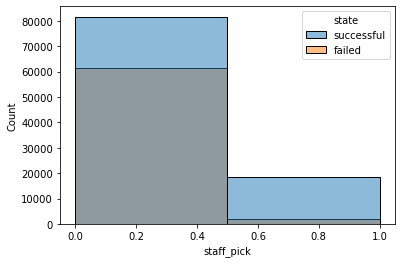

In [20]:
sns.histplot(data=df, x='staff_pick', hue='state', bins=2);

Most projects are not highligted by __staff pick__. But the __fail rate is much lower__, if they are!

# Goal

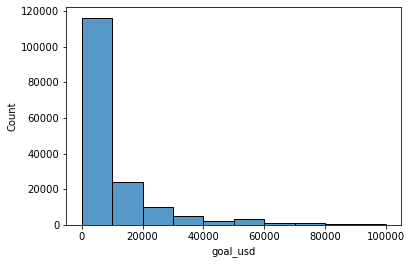

In [37]:
sns.histplot(data=df, x='goal_usd', bins=10);

Data is right skewed, because limit at 0.

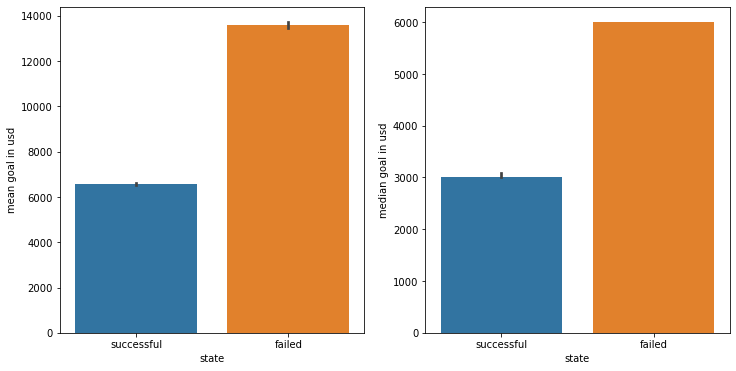

In [22]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.barplot(data=df, x='state', y='goal_usd', ax=ax[0])
sns.barplot(data=df, x='state', y='goal_usd', ax=ax[1], estimator=np.median);
ax[0].set_ylabel('mean goal in usd')
ax[1].set_ylabel('median goal in usd');

Most projects fail because goals are too ambigious.

# usd_type

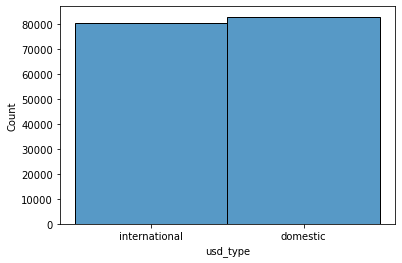

In [23]:
sns.histplot(data=df, x='usd_type');

Data is very balanced. Same amount of domestic and international projects.

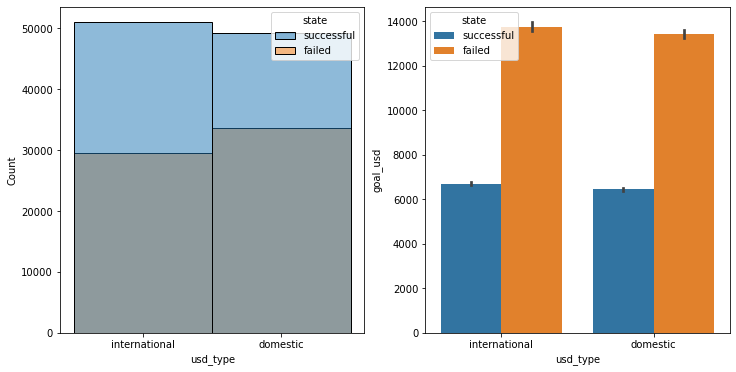

In [24]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.histplot(data=df, x='usd_type', hue='state', ax=ax[0])
sns.barplot(data=df, x='usd_type', y='goal_usd', hue='state', ax=ax[1]);

__Shipping__ has __no influence__ on success, neither on goal!

# backers_count

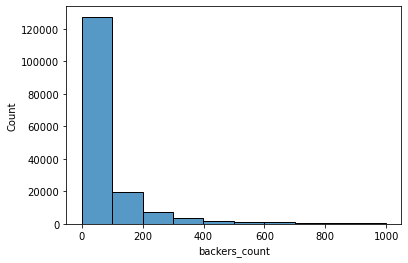

In [39]:
sns.histplot(data=df, x='backers_count', bins=10);

Data is right skewed, because of limit at 0.

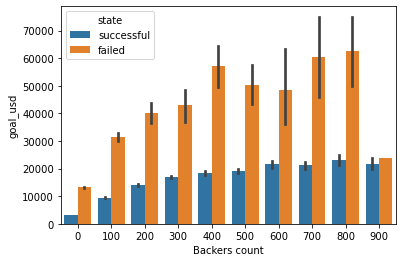

In [40]:
# Create bins
tmp_df = df.copy()
stepsize=100
labels = np.arange(df.backers_count.min(), df.backers_count.max(), stepsize)
nbins = labels.shape[0]
tmp_df['bins'] = pd.cut(df.backers_count, bins=nbins, labels=labels)

sns.barplot(data=tmp_df, x='bins', y='goal_usd', hue='state');
plt.xlabel('Backers count');

Data is __logarithmic__. Last value is due to few observations.

# usd_pledged
look relative to goal

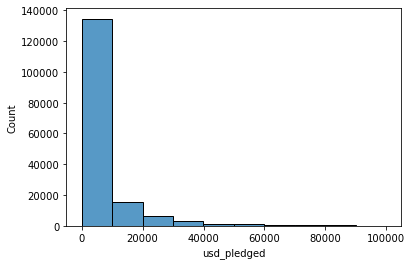

In [42]:
sns.histplot(data=df, x='usd_pledged', bins=10);

Data is not at all normal distributed, because of large outliers. __Remove__ large Outliers!

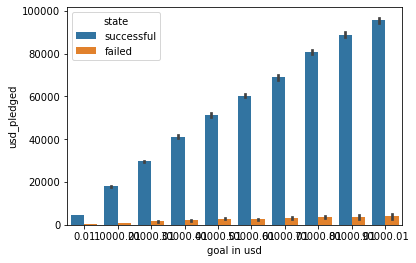

In [43]:
# Create bins
tmp_df = df.copy()
stepsize=10000
labels = np.arange(df.goal_usd.min(), df.goal_usd.max(), stepsize)
nbins = labels.shape[0]
tmp_df['bins'] = pd.cut(df.goal_usd, bins=nbins, labels=labels)

sns.barplot(data=tmp_df, x='bins', y='usd_pledged', hue='state')
plt.xlabel('goal in usd');

Of course the amount of pledged money rises linearly with the higher goal for success. In mean the failed projects had only a small amount pledged. In mean no projects almost failed, but drastically.

# Feature Importance

# Todo:
* goal 1 USD??
* goal logarithmic?

# Blurb to dict

decision tree show where obs fails?